In [1]:
import numpy as np
import yfinance as yf
import pandas as pd

In [19]:

def rolling_correlation_2ticker(
    ticker1,
    ticker2,
    start_date="1990-01-01",
    end_date=None,
    window_days=252,
    use_adjusted=True,
):
    """
    Calculate rolling correlation between two stocks over a date range.
    
    Parameters:
    - ticker1, ticker2: Stock tickers (e.g., "VTI", "QQQM")
    - start_date, end_date: Date range for analysis
    - window_days: Rolling window size in trading days (default 252 = 1 year)
    - use_adjusted: Use adjusted close (True) or close (False)
    
    Returns:
    - Dictionary with rolling correlation stats and time series
    """
    # 1. Fetch price data for both tickers
    raw_data = yf.download(
        [ticker1, ticker2],
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=True,
    )
    
    price_field = "Close"
    if use_adjusted and isinstance(raw_data.columns, pd.MultiIndex) and "Adj Close" in raw_data.columns.get_level_values(0):
        price_field = "Adj Close"
    
    data = raw_data[price_field]
    
    # 2. Get price series and calculate returns
    series1 = data[ticker1].dropna()
    series2 = data[ticker2].dropna()
    
    # Align dates (keep only overlapping period)
    common_idx = series1.index.intersection(series2.index)
    series1 = series1.loc[common_idx]
    series2 = series2.loc[common_idx]
    
    if len(series1) < window_days:
        return {
            "Error": f"Not enough data; need {window_days} days but only have {len(series1)}"
        }
    
    # 3. Calculate returns (log returns more stable)
    returns1 = np.log(series1 / series1.shift(1)).dropna()
    returns2 = np.log(series2 / series2.shift(1)).dropna()
    
    # Align returns
    common_idx = returns1.index.intersection(returns2.index)
    returns1 = returns1.loc[common_idx]
    returns2 = returns2.loc[common_idx]
    
    # 4. Calculate rolling correlation
    rolling_corr = returns1.rolling(window=window_days).corr(returns2)
    
    # 5. Compute summary statistics
    stats = {
        "Ticker 1": ticker1,
        "Ticker 2": ticker2,
        "Start Date": str(rolling_corr.index[0].date()),
        "End Date": str(rolling_corr.index[-1].date()),
        "Window (days)": window_days,
        "Mean Correlation": round(rolling_corr.mean(), 3),
        "Median Correlation": round(rolling_corr.median(), 3),
        "Std Dev Correlation": round(rolling_corr.std(), 3),
        "Min Correlation": round(rolling_corr.min(), 3),
        "Max Correlation": round(rolling_corr.max(), 3),
        "Current Correlation": round(rolling_corr.iloc[-1], 3) if not pd.isna(rolling_corr.iloc[-1]) else np.nan,
    }
    
    return {
        "stats": stats,
        "rolling_correlation": rolling_corr,
    }


Stats:
  Ticker 1: TCAF
  Ticker 2: VTI
  Start Date: 2023-06-16
  End Date: 2025-12-24
  Window (days): 252
  Mean Correlation: 0.97
  Median Correlation: 0.969
  Std Dev Correlation: 0.008
  Min Correlation: 0.951
  Max Correlation: 0.981
  Current Correlation: 0.973


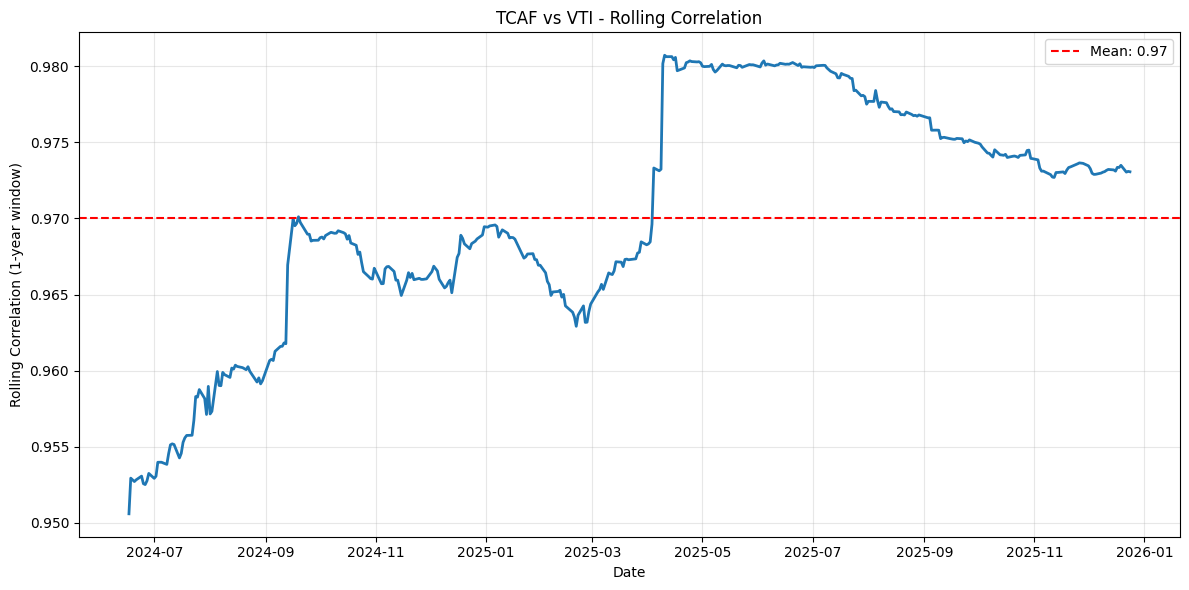

In [27]:
# Rolling correlation between two stocks
result = rolling_correlation_2ticker("TCAF", "VTI", start_date="2000-01-01", end_date=None, window_days=252)
print("Stats:")
for key, value in result["stats"].items():
    print(f"  {key}: {value}")

# Plot rolling correlation over time
rolling_corr_series = result["rolling_correlation"]
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr_series.index, rolling_corr_series.values, linewidth=2)
plt.axhline(y=result["stats"]["Mean Correlation"], color='r', linestyle='--', label=f"Mean: {result['stats']['Mean Correlation']}")
plt.xlabel("Date")
plt.ylabel("Rolling Correlation (1-year window)")
plt.title(f"{result['stats']['Ticker 1']} vs {result['stats']['Ticker 2']} - Rolling Correlation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Compounding-growth summary (normalized to $1):


,Start,End,Final($1->),CAGR
Ticker,,,,
DYNF,2022-02-25,2025-12-24,1.9578,19.19%
QQQ,2022-02-25,2025-12-24,1.8792,17.92%
VTI,2022-02-25,2025-12-24,1.6619,14.19%
DUHP,2022-02-25,2025-12-24,1.6246,13.52%
AVUV,2022-02-25,2025-12-24,1.4541,10.28%


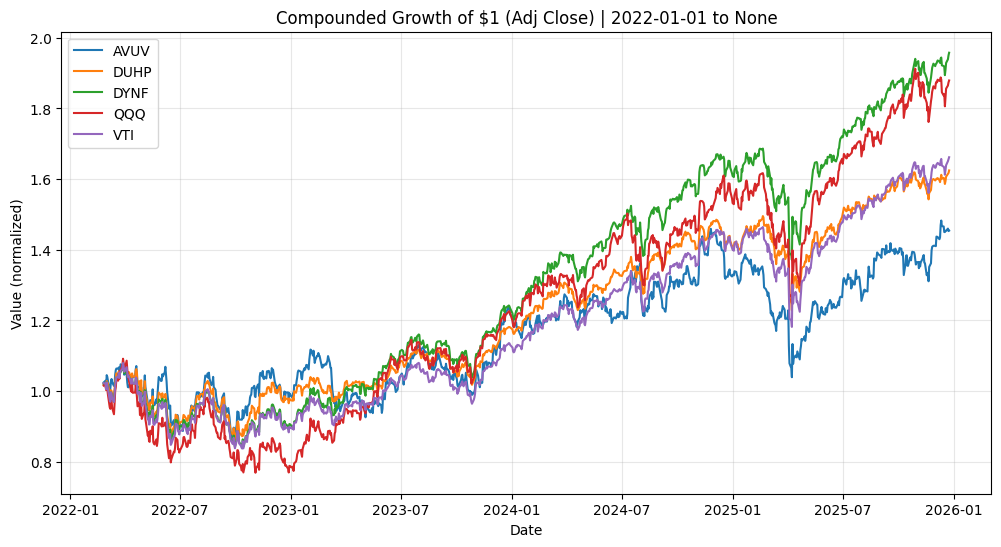

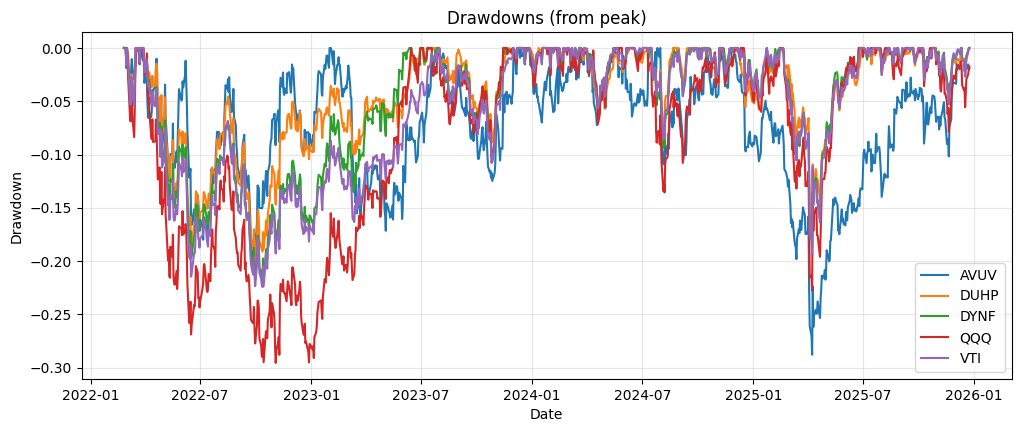

In [83]:
# If needed (run once): !pip install yfinance pandas matplotlib

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# User settings
# ----------------------------
tickers = ["VTI", "AVUV", "DYNF", "DUHP", "QQQ"]      # 2+ tickers
start = "2022-01-01"
end   = None

initial_value = 1.0                 # normalize to $1 (compounding growth)
use_log_scale = False               # set True for log-scale plot
show_drawdown = True                # optional extra chart

# ----------------------------
# Download data (Adjusted Close)
# ----------------------------
px = yf.download(
    tickers,
    start=start,
    end=end,
    auto_adjust=False,      # keep Adj Close available
    progress=False
)["Adj Close"]

# Ensure DataFrame even if only 1 ticker
if isinstance(px, pd.Series):
    px = px.to_frame()

# Drop rows with missing values (or you can forward-fill if you prefer)
px = px.dropna(how="any")

# ----------------------------
# Compute daily returns and compounded growth of $1
# ----------------------------
daily_ret = px.pct_change().dropna()
growth = (1 + daily_ret).cumprod() * initial_value  # compounded index

# ----------------------------
# Metrics: CAGR (compounded annual growth rate)
# ----------------------------
# Use trading-day approximation or actual elapsed years:
elapsed_years = (growth.index[-1] - growth.index[0]).days / 365.25
final_vals = growth.iloc[-1]
cagr = (final_vals / initial_value) ** (1 / elapsed_years) - 1

summary = pd.DataFrame({
    "Start": growth.index[0].date(),
    "End": growth.index[-1].date(),
    "Final($1->)": final_vals.round(4),
    "CAGR": (cagr * 100).round(2).astype(str) + "%"
}).sort_values("Final($1->)", ascending=False)

print("Compounding-growth summary (normalized to $1):")
display(summary)

# ----------------------------
# Plot: Compounded growth of $1
# ----------------------------
plt.figure(figsize=(12, 6))
for col in growth.columns:
    plt.plot(growth.index, growth[col], label=col)

plt.title(f"Compounded Growth of ${initial_value:.0f} (Adj Close) | {start} to {end}")
plt.xlabel("Date")
plt.ylabel("Value (normalized)")
if use_log_scale:
    plt.yscale("log")
    plt.ylabel("Value (log scale, normalized)")

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ----------------------------
# Optional: Drawdown chart (peak-to-trough % decline)
# ----------------------------
if show_drawdown:
    running_max = growth.cummax()
    drawdown = growth / running_max - 1.0

    plt.figure(figsize=(12, 4.5))
    for col in drawdown.columns:
        plt.plot(drawdown.index, drawdown[col], label=col)
    plt.title("Drawdowns (from peak)")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


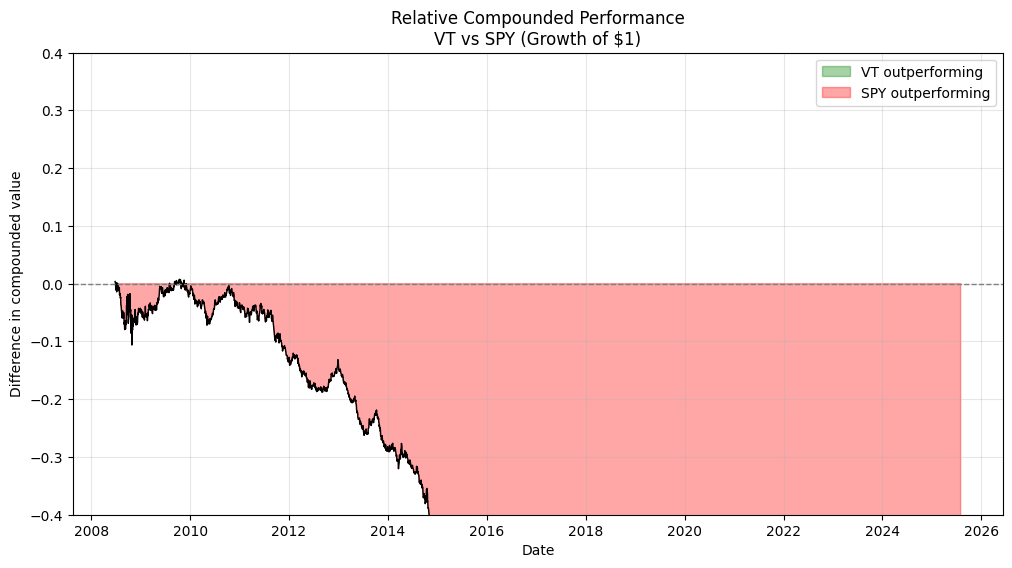

In [114]:
# If needed (run once): !pip install yfinance pandas matplotlib

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# User settings
# ----------------------------
ticker_1 = "SPY"     # baseline
ticker_2 = "VT"     # comparison
start = "2000-10-01"
end   = "2025-08-01"

initial_value = 1.0

# ----------------------------
# Download adjusted close data
# ----------------------------
px = yf.download(
    [ticker_1, ticker_2],
    start=start,
    end=end,
    auto_adjust=False,
    progress=False
)["Adj Close"].dropna()

# ----------------------------
# Compute compounded growth ($1)
# ----------------------------
daily_ret = px.pct_change().dropna()
growth = (1 + daily_ret).cumprod() * initial_value

g1 = growth[ticker_1]
g2 = growth[ticker_2]

# ----------------------------
# Relative difference
# Positive → ticker_2 better
# Negative → ticker_1 better
# ----------------------------
diff = g2 - g1

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(12, 6))

plt.plot(diff.index, diff, color="black", linewidth=1)

plt.fill_between(
    diff.index,
    diff,
    0,
    where=(diff > 0),
    interpolate=True,
    alpha=0.35,
    label=f"{ticker_2} outperforming",
    color="green"
)

plt.fill_between(
    diff.index,
    diff,
    0,
    where=(diff < 0),
    interpolate=True,
    alpha=0.35,
    label=f"{ticker_1} outperforming",
    color="red"
)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.title(
    f"Relative Compounded Performance\n"
    f"{ticker_2} vs {ticker_1} (Growth of $1)"
)
plt.ylabel("Difference in compounded value")
plt.xlabel("Date")
plt.ylim(-0.4, 0.4)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
